In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime
from scipy.stats import norm

## Collect Data for ETFs

In [5]:
# Define start and end date
start_date = datetime.datetime(2021, 6, 30)
end_date = datetime.datetime(2024, 6, 30)

# Fetch data for different asset classes
## iShares Gold Trust Micro - IAUM
## iShares Core U.S. Aggregate Bond ETF - AGG
## SPDR S&P 500 ETF Trust - SPY

df = yf.download(['SPY','AGG','IAUM'], start=start_date, end=end_date)['Adj Close']
df.index = pd.to_datetime(df.index)
df = df.dropna()

[*********************100%%**********************]  3 of 3 completed


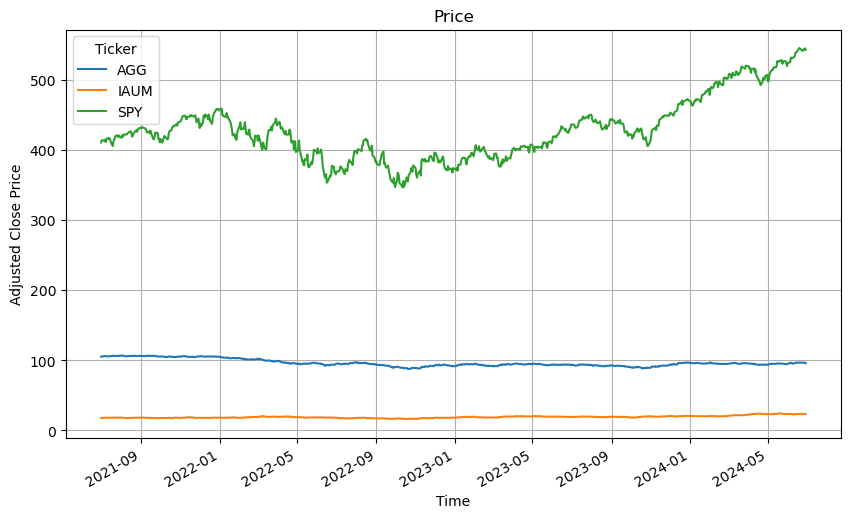

In [12]:
df = pd.DataFrame(df, index=pd.to_datetime(df.index))

# Plot the dataframe to visualize
ax = df.plot.line(xlabel="Time", ylabel="Adjusted Close Price", title="Price", figsize=(10, 6))
ax.grid(True)

In [17]:
# Calculate percentage change per stock
returns = df.pct_change().dropna()

# Define the new weights for SPY, AGG, and IAUM as 50%, 30%, and 20%
weights = np.array([0.30, 0.20, 0.50])  # Order corresponds to AGG, IAUM, SPY

# Calculate portfolio returns using the weighted sum of individual returns
port_returns = returns.dot(weights)

Date
2021-07-02    0.005881
2021-07-06    0.001058
2021-07-07    0.003009
2021-07-08   -0.003893
2021-07-09    0.005065
                ...   
2024-06-24   -0.000603
2024-06-25    0.000949
2024-06-26   -0.002626
2024-06-27    0.003723
2024-06-28   -0.003530
Length: 752, dtype: float64

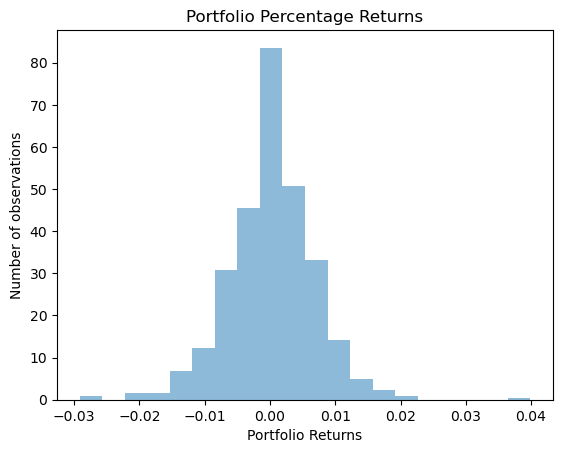

In [26]:
# Plot the portfolio returns
plt.hist(port_returns, bins=20, density=True, alpha=0.5)
plt.xlabel("Portfolio Returns")
plt.ylabel("Number of observations")
plt.title(f"Portfolio Percentage Returns")
plt.show()

## Historical method

In [20]:
# Assume initial portfolio value
initial_portfolio = 100000

# Calculate the portfolio's VaR at 95% confidence level
confidence_level = 0.95
# Calculate P(Return <= VAR) = alpha
var = port_returns.quantile(q=1-confidence_level)
# Calculate CVAR by computing the average returns below the VAR level
cvar = port_returns[port_returns <= var].mean()

# Multiply the VaR and CVaR by the initial investment value to get the absolute value
var_value = var * initial_portfolio
cvar_value = cvar * initial_portfolio

# Calculate the monthly and annual VaR using the scaling formula
monthly_var = var_value * np.sqrt(21)
annual_var = var_value * np.sqrt(252)

# Calculate the monthly and annual CVaR using the same scaling formula
monthly_cvar = cvar_value * np.sqrt(21)
annual_cvar = cvar_value * np.sqrt(252)

# Print the results
print(f"Daily VaR at {confidence_level} confidence level: {var_value:.2f}")
print(f"Monthly VaR at {confidence_level} confidence level: {monthly_var:.2f}")
print(f"Annual VaR at {confidence_level} confidence level: {annual_var:.2f}")

print(f"Daily CVaR at {confidence_level} confidence level: {cvar_value:.2f}")
print(f"Monthly CVaR at {confidence_level} confidence level: {monthly_cvar:.2f}")
print(f"Annual CVaR at {confidence_level} confidence level: {annual_cvar:.2f}")

Daily VaR at 0.95 confidence level: -1049.28
Monthly VaR at 0.95 confidence level: -4808.40
Annual VaR at 0.95 confidence level: -16656.77
Daily CVaR at 0.95 confidence level: -1452.53
Monthly CVaR at 0.95 confidence level: -6656.32
Annual CVaR at 0.95 confidence level: -23058.16


## Parametric Method

In [45]:
# Calculate the portfolio's VaR at 95% confidence level
confidence_level = 0.95

mean = port_returns.mean()
cov_matrix = returns.cov()
port_std_dev = np.sqrt(weights.T @ cov_matrix @ weights)

confidence_level = 0.95
z_value = norm.ppf(q=1-confidence_level)

# Calculate P(Return <= VAR) = alpha
var = -( mean - port_std_dev * z_value)
# Calculate CVAR by computing the average returns below the VAR level
cvar = port_returns[port_returns <= var].mean()

# Multiply the VaR and CVaR by the initial investment value to get the absolute value
var_value = var * initial_portfolio
cvar_value = cvar * initial_portfolio

# Calculate the monthly and annual VaR using the scaling formula
monthly_var = var_value * np.sqrt(21)
annual_var = var_value * np.sqrt(252)

# Calculate the monthly and annual CVaR using the same scaling formula
monthly_cvar = cvar_value * np.sqrt(21)
annual_cvar = cvar_value * np.sqrt(252)

# Print the results
print(f"Daily VaR at {confidence_level} confidence level: {var_value:.2f}")
print(f"Monthly VaR at {confidence_level} confidence level: {monthly_var:.2f}")
print(f"Annual VaR at {confidence_level} confidence level: {annual_var:.2f}")

print(f"Daily CVaR at {confidence_level} confidence level: {cvar_value:.2f}")
print(f"Monthly CVaR at {confidence_level} confidence level: {monthly_cvar:.2f}")
print(f"Annual CVaR at {confidence_level} confidence level: {annual_cvar:.2f}")

Daily VaR at 0.95 confidence level: -1094.76
Monthly VaR at 0.95 confidence level: -5016.84
Annual VaR at 0.95 confidence level: -17378.83
Daily CVaR at 0.95 confidence level: -1511.26
Monthly CVaR at 0.95 confidence level: -6925.45
Annual CVaR at 0.95 confidence level: -23990.47


## Monte Carlo Simulation

In [62]:
# Set random seed for reproducibility
np.random.seed(123)

initialPortfolio = 100000

n_simulation = 100
T = 252 
meanM = np.full(shape=(T, len(weights)), fill_value=mean_returns).T

sim_pct_change = np.full(shape=(T, n_simulation), fill_value=0.0)
for m in range(n_simulation):
    # Generate random numbers matrix for each day in the timeframe T and each stock in the portfolio
    Z = np.random.normal(size=(T, len(weights)))
    # Obtain the Cholesky decomposition of the covariance matrix
    # factoring the covariance matrix into the product of a lower triangular matrix (L) and its conjugate transpose (L*)
    L = np.linalg.cholesky(cov_matrix)
    # Calculate daily percentage change using the Cholesky decomposition
    daily_pct_change = meanM + np.inner(L, Z)
    # Calculate the simulated portfolio percentage change for each day in the timeframe T
    sim_pct_change[:,m] = np.inner(weights, daily_pct_change.T)

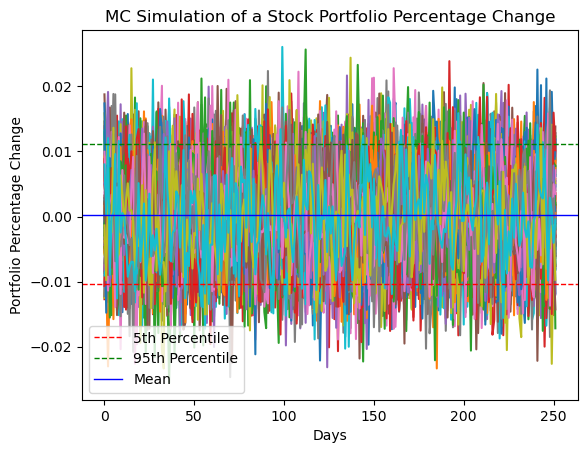

In [63]:
# Plotting
plt.plot(sim_pct_change)

plt.axhline(np.percentile(sim_pct_change,5), color='r', linestyle='dashed', linewidth=1, label='5th Percentile')
plt.axhline(np.percentile(sim_pct_change,95), color='g', linestyle='dashed', linewidth=1,  label='95th Percentile')
plt.axhline(np.mean(sim_pct_change), color='b', linestyle='solid', linewidth=1, label='Mean')

plt.legend()
plt.ylabel('Portfolio Percentage Change')
plt.xlabel('Days')
plt.title('MC Simulation of a Stock Portfolio Percentage Change')
plt.show()

In [66]:
# Parameters
np.random.seed(123)  # Set random seed for reproducibility
initialPortfolio = 100000
n_simulation = 1000  # Number of simulations
T = 252  # Number of trading days in a year
confidence_level = 0.95

# Set weights for the portfolio
meanM = np.full(shape=(T, len(weights)), fill_value=mean_returns).T

# Simulate daily percentage change
sim_pct_change = np.full(shape=(T, n_simulation), fill_value=0.0)
for m in range(n_simulation):
    Z = np.random.normal(size=(T, len(weights)))  # Generate random numbers
    L = np.linalg.cholesky(cov_matrix)  # Cholesky decomposition
    daily_pct_change = meanM + L @ Z.T  # Calculate daily percentage change
    sim_pct_change[:, m] = weights @ daily_pct_change  # Portfolio daily percentage change

# Convert sim_pct_change to DataFrame for easier manipulation
port_pct_change = pd.Series(sim_pct_change[-1, :])  # Last day percentage change for all simulations

# Calculate VaR and CVaR at 95% confidence level
mcVAR = port_pct_change.quantile(1 - confidence_level)
mcCVAR = port_pct_change[port_pct_change <= mcVAR].mean()

# Multiply the VaR and CVaR by the initial investment value to get the absolute value
var_value = mcVAR * initial_portfolio
cvar_value = mcCVAR * initial_portfolio

# Calculate the monthly and annual VaR using the scaling formula
monthly_var = var_value * np.sqrt(21)
annual_var = var_value * np.sqrt(252)

# Calculate the monthly and annual CVaR using the same scaling formula
monthly_cvar = cvar_value * np.sqrt(21)
annual_cvar = cvar_value * np.sqrt(252)

# Print the results
print(f"Daily VaR at {confidence_level} confidence level: {var_value:.2f}")
print(f"Monthly VaR at {confidence_level} confidence level: {monthly_var:.2f}")
print(f"Annual VaR at {confidence_level} confidence level: {annual_var:.2f}")

print(f"Daily CVaR at {confidence_level} confidence level: {cvar_value:.2f}")
print(f"Monthly CVaR at {confidence_level} confidence level: {monthly_cvar:.2f}")
print(f"Annual CVaR at {confidence_level} confidence level: {annual_cvar:.2f}")

Daily VaR at 0.95 confidence level: -1077.75
Monthly VaR at 0.95 confidence level: -4938.87
Annual VaR at 0.95 confidence level: -17108.74
Daily CVaR at 0.95 confidence level: -1306.70
Monthly CVaR at 0.95 confidence level: -5988.03
Annual CVaR at 0.95 confidence level: -20743.16


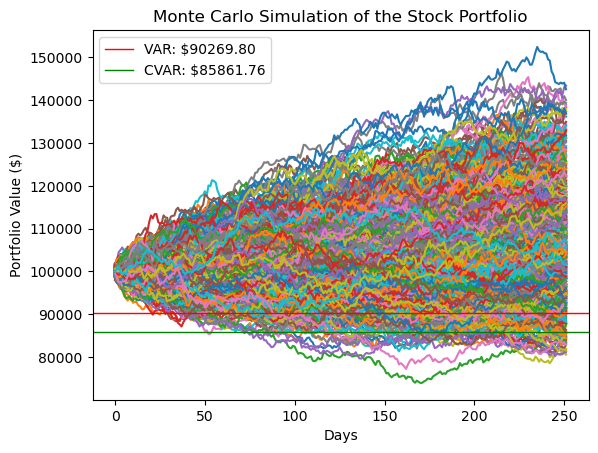

In [65]:
# Create a DataFrame to fill with 0 for portfolio returns
portfolio_returns = np.zeros((T, n_simulation))

# Convert percentage change to actual portfolio value
for m in range(n_simulation):
    portfolio_returns[:, m] = np.cumprod(sim_pct_change[:, m] + 1) * initialPortfolio

# Select the last simulated trading day records
last_portfolio_returns = portfolio_returns[-1, :]  # Portfolio values at the end of the simulation

# Calculate VaR and CVaR at 95% confidence level of the portfolio returns
mc_var_returns = np.percentile(last_portfolio_returns, 100 * (1 - confidence_level))
mc_cvar_returns = last_portfolio_returns[last_portfolio_returns <= mc_var_returns].mean()


#Plotting
plt.plot(portfolio_returns)

plt.axhline(mc_var_returns, color='r', linewidth=1, label=f'VAR: ${mc_var_returns:.2f}')
plt.axhline(mc_cvar_returns, color='g', linewidth=1,  label=f'CVAR: ${mc_cvar_returns:.2f}')

plt.legend(loc='upper left')
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('Monte Carlo Simulation of the Stock Portfolio')
plt.show()

In [ ]:
import cv2
import numpy as np

# Load the image
image_path = "/mnt/data/image.png"
img = cv2.imread(image_path)

# Video settings
height, width, _ = img.shape
video_path = "/mnt/data/simulation_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec
fps = 10  # Frames per second
n_frames = 100  # Number of frames

# Initialize the video writer
out = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

# Create frames by slightly modifying the image and write to video
for i in range(n_frames):
    # Example of modification: add a simple effect (e.g., darkening over time)
    frame = img.copy()
    frame = (frame * (1 - i / n_frames)).astype(np.uint8)  # Gradual darkening
    out.write(frame)

# Release the video writer
out.release()

video_path  # To check the path of the video
